In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, PCA

In [2]:
class SVD(BaseEstimator, TransformerMixin):
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        return self        
    
    def transform(self, X):
        X_ = X.copy()
        U, s, W = np.linalg.svd(X_)
        V = W.T
        
        # for reconstruction
        #D = np.zeros_like(X_, dtype=float)
        #D[np.diag_indices(min(X_.shape))] = s
        
        U_trunc, S_trunc, V_trunc = self.truncate(U, s, V, self.k)

        trunc_X = U_trunc @ np.diag(S_trunc)
        reduced_data = pd.DataFrame(trunc_X)
        return reduced_data

    @staticmethod
    def truncate(U, S, V, k):
        U_trunc = U[:, :k]
        S_trunc = S[:k]
        V_trunc = V[:k, :]
        return U_trunc, S_trunc, V_trunc

In [3]:
class SVD_(BaseEstimator, TransformerMixin):
    def __init__(self, k=2):
        self.k = k
        self.W = None

    def fit(self, X, y=None):
        X_ = X.copy()
        U, s, W = np.linalg.svd(X_) # vector s of lambdas is already returned sorted
        V = W.T
        #pairs = [(np.abs(s[i]), V[:, i]) for i in range(len(s))]
        #self.W = np.hstack([pairs[i][1][:, np.newaxis] for i in range(self.k)])
        self.W = np.hstack([V[:, i][:, np.newaxis] for i in range(self.k)])
        return self

    def transform(self, X):
        return X.dot(self.W)

In [33]:
data = load_iris(as_frame=True)
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=123)

In [5]:
X_train.sample(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
59,5.2,2.7,3.9,1.4
21,5.1,3.7,1.5,0.4
0,5.1,3.5,1.4,0.2


In [6]:
estimator = SVC(kernel='linear', gamma='scale', degree=2)

In [7]:
pipe_one = make_pipeline(MinMaxScaler(), SVD_(k=3), estimator)
pipe_two = make_pipeline(MinMaxScaler(), TruncatedSVD(n_components=3, algorithm='arpack'), estimator)

In [8]:
pipe_one.fit(X_train, y_train)
print(classification_report(y_test, pipe_one.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [9]:
pipe_two.fit(X_train, y_train)
print(classification_report(y_test, pipe_two.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [25]:
pipe_three = make_pipeline(MinMaxScaler(), PCA(n_components=3), estimator)
pipe_four = make_pipeline(MinMaxScaler(), estimator)

In [26]:
pipe_three.fit(X_train, y_train)
print(classification_report(y_train, pipe_three.predict(X_train)))
print(classification_report(y_test, pipe_three.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.90      1.00      0.95        35
           2       1.00      0.89      0.94        35

    accuracy                           0.96       105
   macro avg       0.97      0.96      0.96       105
weighted avg       0.97      0.96      0.96       105

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [27]:
pipe_four.fit(X_train, y_train)
print(classification_report(y_train, pipe_four.predict(X_train)))
print(classification_report(y_test, pipe_four.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.90      1.00      0.95        35
           2       1.00      0.89      0.94        35

    accuracy                           0.96       105
   macro avg       0.97      0.96      0.96       105
weighted avg       0.97      0.96      0.96       105

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



Таким образом, при применении метода главных компонент с отбрасыванием наименее информативного признака, качество модели не снижается.

Проверка SVD

In [20]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=123)

In [21]:
pipe_one = make_pipeline(MinMaxScaler(), SVD_(k=25), estimator)
pipe_two = make_pipeline(MinMaxScaler(), TruncatedSVD(n_components=25, algorithm='arpack'), estimator)

In [22]:
pipe_one.fit(X_train, y_train)
print(classification_report(y_train, pipe_one.predict(X_train), digits=3))
print(classification_report(y_test, pipe_one.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.994     0.962     0.978       159
           1      0.978     0.996     0.987       267

    accuracy                          0.984       426
   macro avg      0.986     0.979     0.982       426
weighted avg      0.984     0.984     0.984       426

              precision    recall  f1-score   support

           0      1.000     0.943     0.971        53
           1      0.968     1.000     0.984        90

    accuracy                          0.979       143
   macro avg      0.984     0.972     0.977       143
weighted avg      0.980     0.979     0.979       143



In [23]:
pipe_two.fit(X_train, y_train)
print(classification_report(y_train, pipe_two.predict(X_train), digits=3))
print(classification_report(y_test, pipe_two.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.994     0.962     0.978       159
           1      0.978     0.996     0.987       267

    accuracy                          0.984       426
   macro avg      0.986     0.979     0.982       426
weighted avg      0.984     0.984     0.984       426

              precision    recall  f1-score   support

           0      1.000     0.943     0.971        53
           1      0.968     1.000     0.984        90

    accuracy                          0.979       143
   macro avg      0.984     0.972     0.977       143
weighted avg      0.980     0.979     0.979       143



Из прошлой версии ДЗ

In [38]:
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c choose-tutors
!unzip choose-tutors.zip
!rm choose-tutors.zip
clear_output()

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
TARGET_NAME = 'choose'

In [41]:
train.sample(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
231,231,34.0,3.0,1450.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0
8788,8788,55.0,1.0,2300.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,82.0,1
5271,5271,40.0,0.0,1500.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,62.0,1
2268,2268,57.0,2.0,1500.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0
7860,7860,38.0,2.0,2300.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,85.0,0


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [43]:
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)

In [44]:
train[TARGET_NAME].value_counts(normalize=True)

0    0.8891
1    0.1109
Name: choose, dtype: float64

In [45]:
train.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


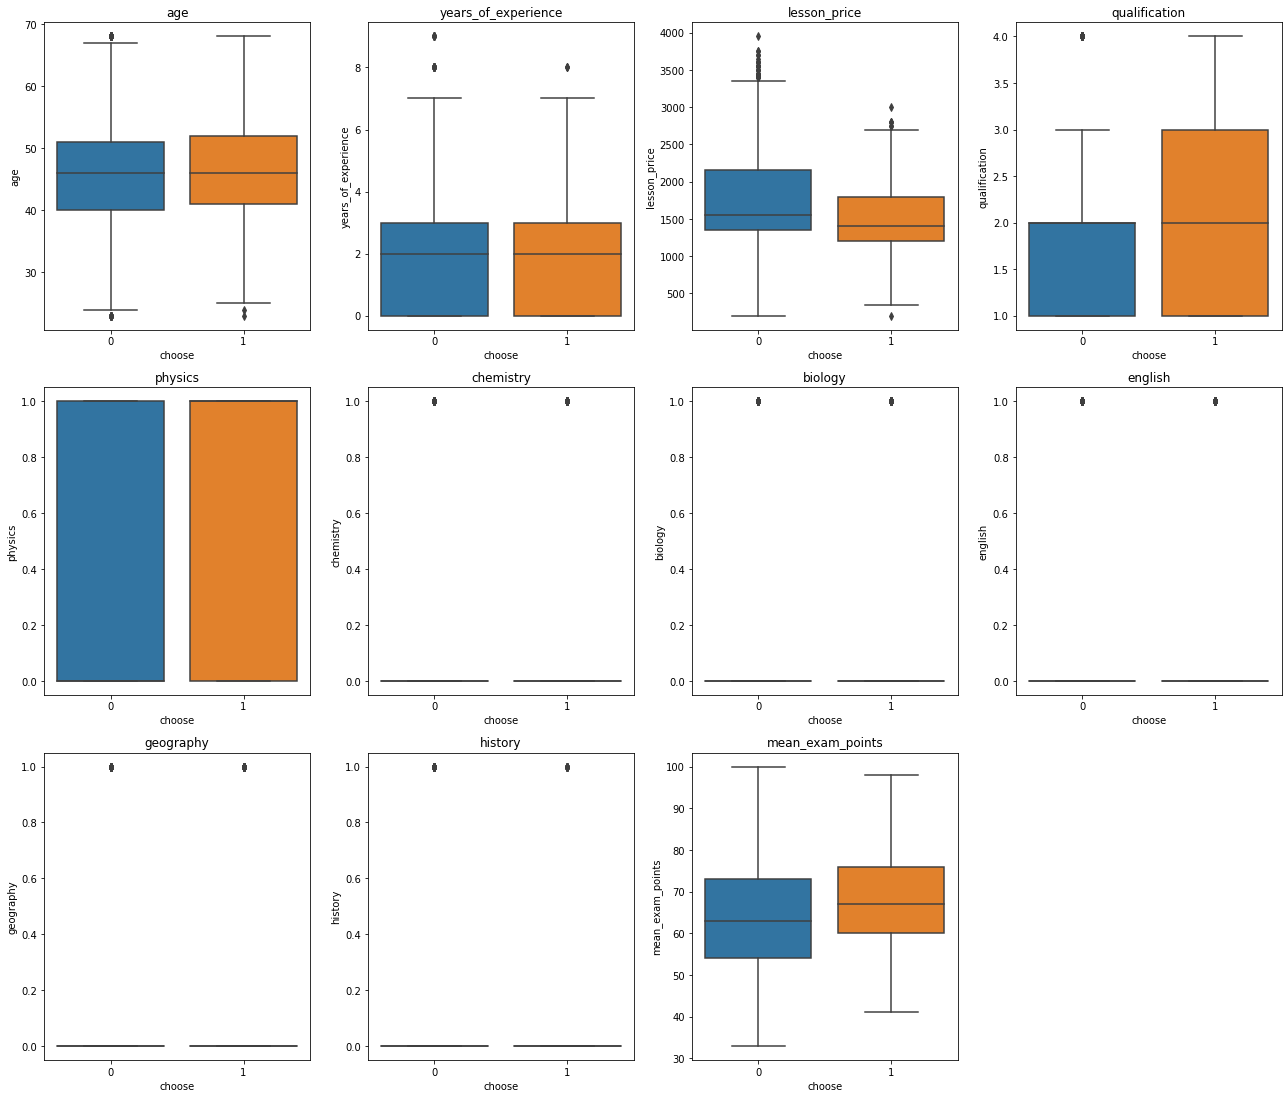

In [46]:
plt.figure(figsize=(18,20))
for idx, column in enumerate(train.columns[:-1], 1):
    plt.subplot(4, 4, idx)
    sns.boxplot(y=train[column], x=train[TARGET_NAME], data=train)
    plt.title(f'{column}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

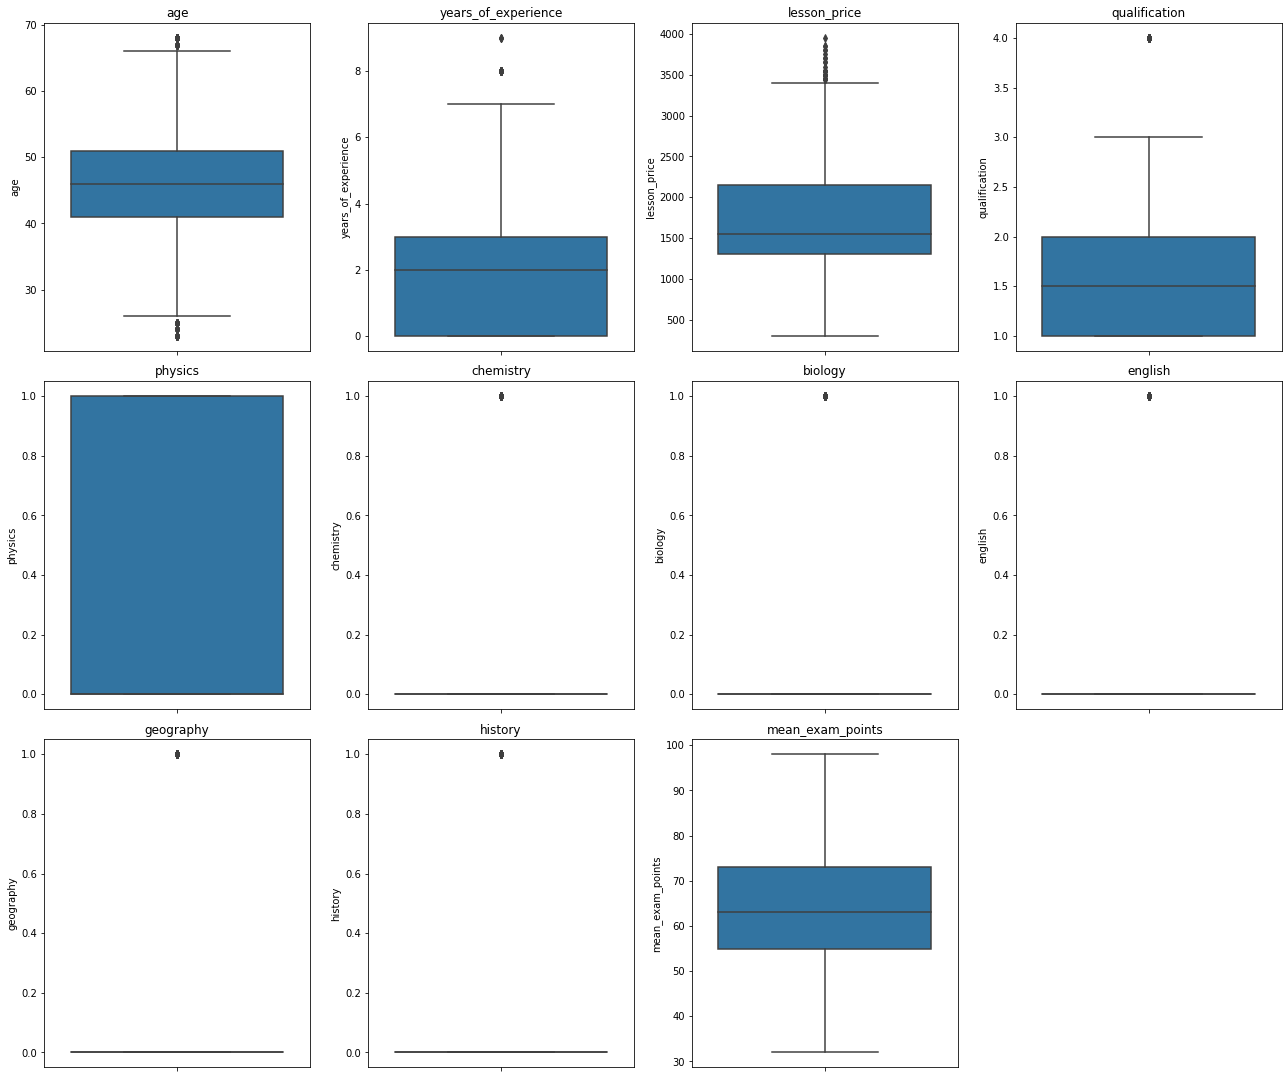

In [47]:
plt.figure(figsize=(18,20))
for idx, column in enumerate(test.columns, 1):
    plt.subplot(4, 4, idx)
    sns.boxplot(y=test[column], data=test)
    plt.title(f'{column}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

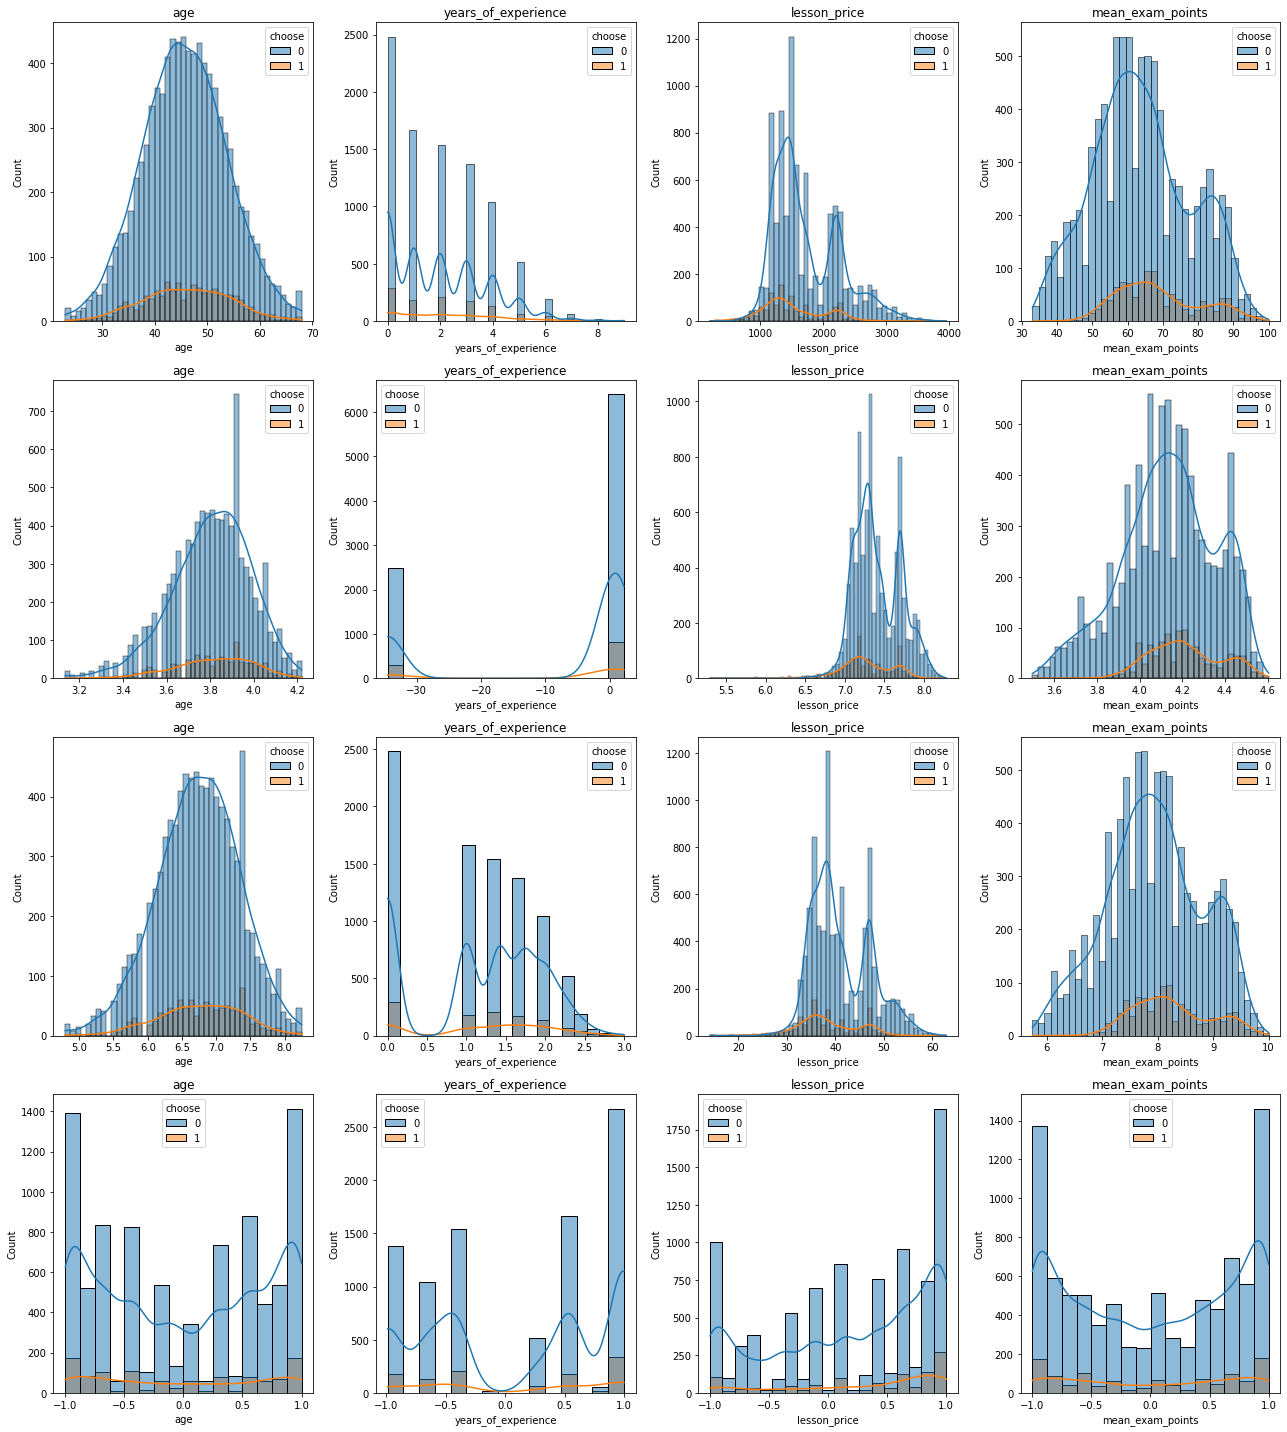

In [48]:
plt.figure(figsize=(18,20))
idx = 1
for func in [None, np.log, np.sqrt, np.cos]:
    for column in train.columns[:3].tolist() + [train.columns[-2]]:
        plt.subplot(4, 4, idx)
        if func is None:
            sns.histplot(x=train[column], hue=train[TARGET_NAME], kde=True)
        else:
            if idx > 4 and idx < 13:
                sns.histplot(x=func(train[column] + 1e-15), hue=train[TARGET_NAME], kde=True)
            else:
                sns.histplot(x=func(train[column]), hue=train[TARGET_NAME], kde=True)
        plt.title(f'{column}')
        idx += 1
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

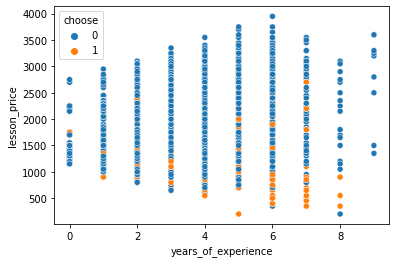

In [49]:
sns.scatterplot(x='years_of_experience', y='lesson_price', data=train, hue=TARGET_NAME)

In [50]:
def _binary_clf_curve(y_true, y_score):
    """
    Github: scikit-learn _binary_clf_curve
    - https://github.com/scikit-learn/scikit-learn/blob/ab93d65/sklearn/metrics/ranking.py#L263
    """
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    distinct_indices = np.where(np.diff(y_score))[0]
    end = np.array([y_true.size - 1])
    threshold_indices = np.hstack((distinct_indices, end))

    thresholds = y_score[threshold_indices]
    tps = np.cumsum(y_true)[threshold_indices]

    fps = (1 + threshold_indices) - tps
    return tps, fps, thresholds

def _roc_auc_score(y_true, y_score):
    tps, fps, _ = _binary_clf_curve(y_true, y_score)
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]
    zero = np.array([0])
    tpr_diff = np.hstack((np.diff(tpr), zero))
    fpr_diff = np.hstack((np.diff(fpr), zero))
    auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2
    return auc

def report(y_true, y_pred):
    accuracy = (y_true == y_pred).mean()
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2*precision * recall / (precision + recall)
    print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

In [51]:
def custom_oversampling(df, target_name=TARGET_NAME, neg_coef=0):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_clss_name = target_counts.argmin()
    disbalance_coef = int(target_counts[major_class_name] / target_counts[minor_clss_name]) - 1
    neg_coef = neg_coef if neg_coef < disbalance_coef else 0
    for i in range(disbalance_coef-neg_coef):
        sample = df[df[target_name] == minor_clss_name].sample(target_counts[minor_clss_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

def reduce_memory(df, verbose=0):
    if verbose != 0:
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    if verbose != 0:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [52]:
class StdScaler:
    def __init__(self):
        self.name = 'scaler'

    def fit(self, X, y=None):
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)

    def transform(self, X):
        X_std = (X - self.mean) / self.std
        return X_std

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [53]:
def combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [81]:
class LogisticRegression:

    def __init__(self, eta=0.01, n_iter=50, l2=0., l1=0., seed=42):
        self.eta = eta
        self.n_iter = n_iter
        self.l2 = l2
        self.l1 = l1
        self.seed = seed
        self.init_weights = False

    def fit(self, X, y):
        if not self.init_weights:
            self.gen = np.random.RandomState(self.seed)
            self.w_ = self.gen.normal(loc=0.0, scale=0.01, size=X.shape[1])
            self.b_ = np.float_(0.)
            self.init_weights = True
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * (X.T.dot(errors) + self.l1*np.sign(self.w_) + self.l2*self.w_) / X.shape[0]
            self.b_ += self.eta * errors.mean()
            loss = (-y.dot(np.log(output + 1e-15)) - ((1 - y).dot(np.log(1 - output + 1e-15))) + self.l1 * np.sum(np.abs(self.w_)) + self.l2*np.sum(np.square(self.w_))) / X.shape[0]
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

    def predict_proba(self, X):
        return self.activation(self.net_input(X))

In [55]:
class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.var_explained = None
        self.cum_var_explained = None
        self.W = None

    def fit(self, X, y=None):
        cov_mat = np.cov(X.T)
        eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
        tot = sum(eigen_vals)
        self.var_explained = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
        self.cum_var_explained = np.cumsum(self.var_explained)
        eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
        eigen_pairs.sort(key=lambda k: k[0], reverse=True)
        self.W = np.hstack([eigen_pairs[i][1][:, np.newaxis] for i in range(self.n_components)])
        return self

    def transform(self, X):
        return X.dot(self.W)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [56]:
class BestSet:
    def __init__(self, k_features=9, scoring=_roc_auc_score, test_size=0.3):
        self.scoring = scoring
        self.k_features = k_features
        self.test_size = test_size

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X, y = X.values, y.values
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y, 
                                                            test_size=self.test_size, 
                                                            stratify=y,
                                                            random_state=1)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        best_indices = self.subsets_[np.argmax(self.scores_)]
        return X[:, best_indices]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        model = LogisticRegression(n_iter=200, eta=.5, l2=10.1, seed=9)
        model.fit(X_train[:, indices], y_train)
        y_pred = model.predict_proba(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [309]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)

train = reduce_memory(train)
test = reduce_memory(test)

In [310]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X['subject_counts'] = X.iloc[:, 3:-1].sum(axis=1)
X['age_group']=pd.cut(X['age'],[0,40,46,51,100],labels=[1,2,3,4]).astype('float')
X['price_group']=pd.cut(X['lesson_price'],[0,1300,1550,2150,10000],labels=[1,2,3,4]).astype('float')
X['qualification_height']=pd.cut(X['qualification'],[-1,3,5],labels=[0,1]).astype('float')

#X['mean_exam_points_group'] = pd.cut(X['mean_exam_points'], [30,60,65,70,74],labels=[1,2,3,4]).astype('float') #
#X['less_rat'] = X['lesson_price'] / X['age'] #
#X['ratio'] = X['lesson_price'] * (X['qualification'] + 1e-10) #
#X['ratio2'] = X['lesson_price'] / (X['years_of_experience'] + 1e-10) #
#X['years_cut'] = pd.cut(X['years_of_experience'], [-1,4,10], labels=[0,1]).astype('float') #
#X['exam_cut'] = pd.cut(X['mean_exam_points'], [50,60,65,74,100],labels=[1,2,3,4]).astype('float') #

mult_columns = ['years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']
for p in mult_columns:
    X[f'{p}_squared'] = np.square(X[p])
    X[f'{p}_cubic'] = np.power(X[p], 3)
    X[f'{p}_log'] = np.log(X[p] + 1e-10)

for p in combinations(mult_columns, r=2):
    X[f'{p[0]}_{p[1]}'] = X[p[0]] * X[p[1]]

for p in combinations(mult_columns, r=3):
    X[f'{p[0]}_{p[1]}_{p[2]}'] = X[p[0]] * X[p[1]] * X[p[2]]


test['subject_counts'] = test.iloc[:, 3:-1].sum(axis=1)
test['age_group']=pd.cut(test['age'],[0,40,46,51,100],labels=[1,2,3,4]).astype('float')
test['price_group']=pd.cut(test['lesson_price'],[0,1300,1550,2150,10000],labels=[1,2,3,4]).astype('float')
test['qualification_height']=pd.cut(test['qualification'],[-1,3,5],labels=[0,1]).astype('float')

#test['mean_exam_points_group'] = pd.cut(test['mean_exam_points'], [30,60,65,70,74],labels=[1,2,3,4]).astype('float')
#test['less_rat'] = test['lesson_price'] / test['age']
#test['ratio'] = test['lesson_price'] * (test['qualification'] + 1e-10)
#test['ratio2'] = test['lesson_price'] / (test['years_of_experience'] + 1e-10)
#test['years_cut'] = pd.cut(test['years_of_experience'], [-1,4,10], labels=[0,1]).astype('float')
#test['exam_cut'] = pd.cut(test['mean_exam_points'], [50,60,65,74,100],labels=[1,2,3,4]).astype('float')

for p in mult_columns:
    test[f'{p}_squared'] = np.square(test[p])
    test[f'{p}_cubic'] = np.power(test[p], 3)
    test[f'{p}_log'] = np.log(test[p] + 1e-10)

for p in combinations(mult_columns, r=2):
    test[f'{p[0]}_{p[1]}'] = test[p[0]] * test[p[1]]

for p in combinations(mult_columns, r=3):
    test[f'{p[0]}_{p[1]}_{p[2]}'] = test[p[0]] * test[p[1]] * test[p[2]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [155]:
# noisy features, skip this step!
"""
X_ = pd.concat([X_train, y_train], axis=1)
train_dict1 = X_.groupby('mean_exam_points')[TARGET_NAME].count().to_dict()
X_train['exam_target_counts'] = X_train['mean_exam_points'].map(train_dict1)
exam_target_median = X_train['exam_target_counts'].median()
X_test['exam_target_counts'] = X_test['mean_exam_points'].map(train_dict1)
X_test['exam_target_counts'].fillna(exam_target_median, inplace=True)

train_dict2 = X_.groupby('age')[TARGET_NAME].count().to_dict()
X_train['age_target_counts'] = X_train['age'].map(train_dict2)
exam_target_median = X_train['age_target_counts'].median()
X_test['age_target_counts'] = X_test['age'].map(train_dict2)
X_test['age_target_counts'].fillna(exam_target_median, inplace=True)

vocab = {}
emb_count_0 = X_.loc[X_[TARGET_NAME] == 0, 'years_of_experience'].count()
emb_count_1 = X_.loc[X_[TARGET_NAME] == 1, 'years_of_experience'].count()
for item in X_['years_of_experience'].unique():
    percent_non_event = X_.loc[((X_[TARGET_NAME] == 0) & (X_['years_of_experience'] == item)), 'years_of_experience'].count() / emb_count_0
    percent_event = X_.loc[((X_[TARGET_NAME] == 1) & (X_['years_of_experience'] == item)), 'years_of_experience'].count() / emb_count_1
    vocab[item] = np.log(percent_non_event / (percent_event + 1e-10))
X_train['woe_exp'] = X_train['years_of_experience'].map(vocab)
X_test['woe_exp'] = X_test['years_of_experience'].map(vocab)

test['exam_target_counts'] = test['mean_exam_points'].map(train_dict1)
test['exam_target_counts'].fillna(exam_target_median, inplace=True)
test['age_target_counts'] = test['age'].map(train_dict2)
test['age_target_counts'].fillna(exam_target_median, inplace=True)
test['woe_exp'] = test['years_of_experience'].map(vocab)
"""

In [156]:
# we cannot simply remove outliers as if they exist in test dataset, we may replace them by IQR range
"""
columns_with_outliers = X.columns[:4].tolist()
X_train['out_mark'] = 0
X_test['out_mark'] = 0
test['out_mark'] = 0
for column in columns_with_outliers:
    q1 = np.quantile(X_train[column], 0.25)
    q3 = np.quantile(X_train[column], 0.75)
    iq_low = q1 - 1.5 * (q3 - q1)
    iq_high = q3 + 1.5 * (q3 - q1)
    X_train.loc[X_train[column] > iq_high, 'out_mark'] = 1
    X_train.loc[X_train[column] < iq_low, 'out_mark'] = 1
    
    X_test.loc[X_test[column] > iq_high, 'out_mark'] = 1
    X_test.loc[X_test[column] < iq_low, 'out_mark'] = 1

    test.loc[test[column] > iq_high, 'out_mark'] = 1
    test.loc[test[column] < iq_low, 'out_mark'] = 1
"""

In [311]:
X_train = custom_oversampling(pd.concat([X_train, y_train], axis=1), neg_coef=3)
X_train, y_train = X_train.drop(TARGET_NAME, axis=1), X_train[TARGET_NAME]

In [312]:
X_train.shape, X_test.shape, test.shape

((10104, 37), (3000, 37), (10000, 37))

In [132]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import KernelPCA

In [313]:
scaler = StdScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled, y_train = SMOTE(sampling_strategy=1., random_state=42, n_jobs=-1).fit_resample(X_train_scaled, y_train)

#pca = CustomPCA(n_components=14)
#X_train_pca = pca.fit_transform(X_train_scaled.values)
#X_test_pca = pca.transform(X_test_scaled.values)

#pca = KernelPCA(n_components=14, kernel='linear', gamma=None, degree=3, random_state=42)
#X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

#squared_columns = X_train_scaled.columns[:4].tolist() + X_train_scaled.columns[-5:].tolist()
#for column in squared_columns:
#    X_train_scaled[f'{column}_square'] = np.square(X_train_scaled[column])
#    X_test_scaled[f'{column}_square'] = np.square(X_test_scaled[column])

selector = BestSet(scoring=_roc_auc_score)
selector.fit(X_train_scaled, y_train)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)
X_test_selected.shape

(3000, 15)

In [314]:
selected_columns = X_train_scaled.columns[list(selector.subsets_[np.argmax(selector.scores_)])]
df = pd.DataFrame(data=np.concatenate([X_train_selected, y_train.values.reshape(-1,1)], axis=1), columns=selected_columns.tolist()+[TARGET_NAME])
corr_mtx = df.corr(method='kendall')
corr_mtx[np.abs(corr_mtx) > 0.3].fillna(0)

,qualification,physics,biology,english,history,mean_exam_points,subject_counts,lesson_price_squared,lesson_price_cubic,lesson_price_log,qualification_cubic,mean_exam_points_log,years_of_experience_qualification,lesson_price_mean_exam_points,lesson_price_qualification_mean_exam_points,choose
qualification,1.000000,0.000000,0.0,0.0,0.0,0.561881,0.650463,0.635119,0.635119,0.635119,1.000000,0.561881,0.348933,0.643055,0.788402,0.0
physics,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.411788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
biology,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
english,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
history,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
mean_exam_points,0.561881,0.000000,0.0,0.0,0.0,1.000000,0.499513,0.461565,0.461565,0.461565,0.561881,1.000000,0.000000,0.711869,0.652137,0.0
subject_counts,0.650463,0.411788,0.0,0.0,0.0,0.499513,1.000000,0.403303,0.403303,0.403303,0.650463,0.499513,0.000000,0.479510,0.550059,0.0
lesson_price_squared,0.635119,0.000000,0.0,0.0,0.0,0.461565,0.403303,1.000000,1.000000,1.000000,0.635119,0.461565,0.000000,0.758295,0.725379,0.0
lesson_price_cubic,0.635119,0.000000,0.0,0.0,0.0,0.461565,0.403303,1.000000,1.000000,1.000000,0.635119,0.461565,0.000000,0.758295,0.725379,0.0
lesson_price_log,0.635119,0.000000,0.0,0.0,0.0,0.461565,0.403303,1.000000,1.000000,1.000000,0.635119,0.461565,0.000000,0.758295,0.725379,0.0


In [315]:
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression(C=0.1)
logreg = LogisticRegression(n_iter=1000, eta=.5, l2=0.5, l1=0.5, seed=100)
logreg.fit(X_train_selected, y_train.values)
train_pred = logreg.predict(X_train_selected)
test_pred = logreg.predict(X_test_selected)
report(y_train, train_pred)
report(y_test, test_pred)
train_probs = logreg.predict_proba(X_train_selected)
test_probs = logreg.predict_proba(X_test_selected)
print(f'roc_auc train: {_roc_auc_score(y_train.values, train_probs):.3f}, roc_auc test {_roc_auc_score(y_test.values, test_probs):.3f}')

Accuracy: 0.776, Precision: 0.724, Recall: 0.674, F1: 0.698
Accuracy: 0.809, Precision: 0.320, Recall: 0.640, F1: 0.427
roc_auc train: 0.859, roc_auc test 0.844


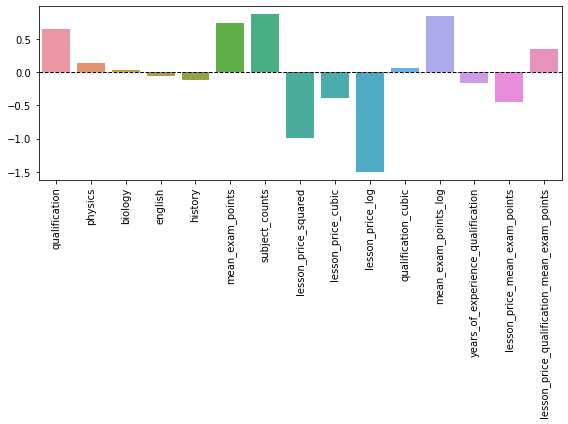

In [316]:
plt.figure(figsize=(8,6))
sns.barplot(x=np.arange(1,len(logreg.w_)+1), y=logreg.w_)
plt.xticks(ticks=np.arange(len(logreg.w_)), labels=selected_columns, rotation=90)
plt.axhline(0, ls='--', c='black', lw=1)
plt.tight_layout()
plt.show()

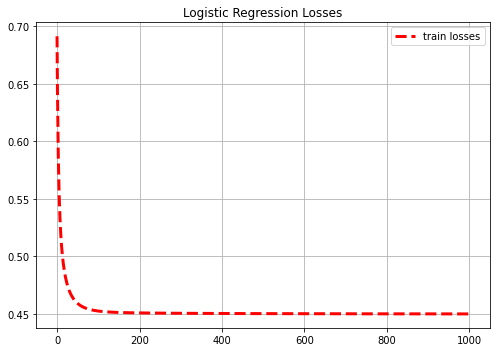

In [317]:
plt.figure(figsize=(7,5))
plt.title('Logistic Regression Losses')
plt.plot(logreg.losses_, lw=3, c='red', ls='--', label='train losses')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [318]:
test_scaled = scaler.transform(test)
#for column in squared_columns:
#    test_scaled[f'{column}_square'] = np.power(test_scaled[column], 3)
test_selected = selector.transform(test_scaled)

Submission on raw data

In [319]:
test_sub = logreg.predict_proba(test_selected)
submission = pd.DataFrame({'Id': test.index, 'choose': test_sub})
submission.sample(3)

,Id,choose
4274,14274,0.049540
7608,17608,0.124270
6000,16000,0.506667


In [ ]:
submission.to_csv('submission.csv', index=False, encoding='utf-8')
!kaggle competitions submit -c choose-tutors -f submission.csv -m 'test1'

Max score: 0.85504 on LeaderBoard (13/115 place)